In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install mat73 
!pip install h5py
%cd '/content/drive/My Drive/UNS/Tesis/Ginzburg-Landau_EQ/CGLE_2D'



/content/drive/My Drive/UNS/Tesis/Ginzburg-Landau_EQ/CGLE_2D


In [31]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler


import mat73
import pickle

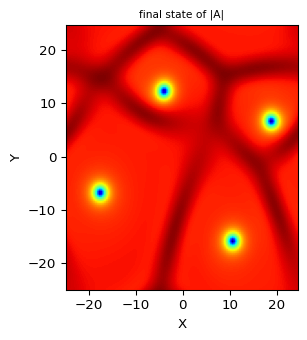

In [32]:
#--------------------------------DATOS------------------------------------------

#igreso el data set



f = mat73.loadmat('Solucion.mat')
Y_Data = np.array(f['U']) # For converting to a NumPy array
Y_Data = np.transpose(Y_Data, (0,2,1))   #Le acomodo los indices para que sea de (t,x,y)
Y_Data = np.transpose(Y_Data, (1,0,2))


#Cargo las series X
f = mat73.loadmat('Xserie.mat')
X = f['X']# For converting to a NumPy array 

#f = mat73.loadmat('Tserie.mat')
#Tdata = f['Tdata'] # For converting to a NumPy array


plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(Y_Data[-1][:][:], extent=[X[0][0], X[0][X.shape[1]-1], X[0][0], X[0][X.shape[1]-1]], aspect='auto', cmap='jet', origin='lower')
plt.title('final state of |A|', fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('puerba1')
plt.show()

y_ = Y_Data[:100]
X_ = Y_Data[1:]


# En caso de tener mas de una variable dependiente con diferente escala
mu1, sigma1 = np.mean( X_ ), np.std( X_ )
mu2, sigma2 = np.mean( y_ ), np.std( y_ )

X_ = (X_ - mu1) / sigma1
y_ = (y_ - mu2) / sigma2


# Separacion de dataset en training y testing
xTrain, xTest = X_[:80, :, :], X_[90:, :, :]
yTrain, yTest = y_[:80, :, :], y_[90:, :, :]


#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar
xTrain = np.reshape( np.array( np.split( np.array( np.split( xTrain, 4, axis=2) ), 4, axis=2) ), (-1, 32, 32) )
yTrain = np.reshape( np.array( np.split( np.array( np.split( yTrain, 4, axis=2) ), 4, axis=2) ), (-1, 32, 32) )


# Separación del dataset de training en training y validación para Early Stopping
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.1, shuffle=False)


# add singleton dimension for input variables (this is for Keras)
xTrain = np.reshape( xTrain, (-1, 32, 32, 1) )
xValid = np.reshape( xValid, (-1, 32, 32, 1) )

# reshape outputs from 2D (40x40) to 1D vector 1600
yTrain = np.reshape( yTrain, (-1, 32 * 32) )
yValid = np.reshape( yValid, (-1, 32 * 32) )

In [61]:
f = mat73.loadmat('Solucion.mat')
Y_Data = np.array(f['U']) # For converting to a NumPy array
Y_Data = np.transpose(Y_Data, (0,2,1))   #Le acomodo los indices para que sea de (t,x,y)
Y_Data = np.transpose(Y_Data, (1,0,2))

for i in range(1,6):

  a = 'Solucion' + str(i)  + '.mat'

  f = mat73.loadmat(a)
  Y_Data1 = np.array(f['U']) # For converting to a NumPy array
  Y_Data1 = np.transpose(Y_Data1, (0,2,1))   #Le acomodo los indices para que sea de (t,x,y)
  Y_Data1 = np.transpose(Y_Data1, (1,0,2))

  Y_Data = np.append(Y_Data,Y_Data1, axis=0)

mu, sigma = 0, 0.01

noise = np.random.normal(mu, sigma, [Y_Data.shape[1],Y_Data.shape[2]])
noise = np.repeat(noise[:, :,np.newaxis], Y_Data.shape[0]-1, axis=2)
noise = np.transpose(noise, (0,2,1))   #Le acomodo los indices para que sea de (t,x,y)
noise = np.transpose(noise, (1,0,2))


X_ = Y_Data[:Y_Data.shape[0]-1]
y_ = Y_Data[1:] + noise



# En caso de tener mas de una variable dependiente con diferente escala
mu1, sigma1 = np.mean( X_ ), np.std( X_ )
mu2, sigma2 = np.mean( y_ ), np.std( y_ )

X_ = (X_ - mu1) / sigma1
y_ = (y_ - mu2) / sigma2

lenX = int(0.9*X_.shape[0])
lenY = int(0.9*y_.shape[0])

# Separacion de dataset en training y testing
xTrain, xTest = X_[:lenX, :, :], X_[lenX:, :, :]
yTrain, yTest = y_[:lenY, :, :], y_[lenX:, :, :]


#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar
xTrain = np.reshape( np.array( np.split( np.array( np.split( xTrain, 4, axis=2) ), 4, axis=2) ), (-1, 32, 32) )
yTrain = np.reshape( np.array( np.split( np.array( np.split( yTrain, 4, axis=2) ), 4, axis=2) ), (-1, 32, 32) )


# Separación del dataset de training en training y validación para Early Stopping
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.1, shuffle=False)


# add singleton dimension for input variables (this is for Keras)
xTrain = np.reshape( xTrain, (-1, 32, 32, 1) )
xValid = np.reshape( xValid, (-1, 32, 32, 1) )

# reshape outputs from 2D (40x40) to 1D vector 1600
yTrain = np.reshape( yTrain, (-1, 32 * 32) )
yValid = np.reshape( yValid, (-1, 32 * 32) )

0.30979522919103947


In [50]:
import tensorflow as tf
from keras import losses
from keras import metrics

from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Convolution2D, Dense, Flatten, MaxPooling2D, Lambda
from keras.optimizers import Adam

tf.keras.backend.clear_session() #borra el grafo de la sesion. Util cuando creamos muchos modelos en una sesion.


########## Construct Layers ##########

input_layer = Input( shape=( 32, 32, 1 ) )

# Convolution layers
conv_1 = Convolution2D( 16, (8,8), strides=(2,2), padding='valid', activation='selu')( input_layer )
conv_2 = Convolution2D( 8, (4,4), padding='valid', activation='selu')( conv_1 )
conv_3 = Convolution2D( 8, (2,2), padding='valid', activation='selu')( conv_2 )

# Max Pooling
pool_1 = MaxPooling2D( pool_size=(2,2) )( conv_3 )
flat = Flatten()(pool_1)

# dense (fully-connected) layer
output_layer = Dense( units=32*32, activation='linear' )( flat )



########## Train CNN ###########

myModel = Model( inputs=input_layer, outputs=output_layer )
myOpt = Adam( lr=0.001 )
myModel.compile( loss='mean_squared_error', optimizer=myOpt )

# show the architecture and the parameters
print(myModel.summary())


es = EarlyStopping(monitor='loss',   #controlo el error
                       mode='min',            #si asciende cortala flaco
                       min_delta = 0.0009,
                       patience=150,           #paciencia para que siga si es q sube porque hay ruido
                       restore_best_weights=True,  #se queda con la mejor
                       verbose=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         2056      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 8)           264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1320

Train on 7833 samples, validate on 871 samples
Epoch 1/300
 - 5s - loss: 0.1084 - val_loss: 0.1190
Epoch 2/300
 - 5s - loss: 0.1019 - val_loss: 0.1137
Epoch 3/300
 - 5s - loss: 0.1024 - val_loss: 0.1140
Epoch 4/300
 - 5s - loss: 0.1001 - val_loss: 0.1222
Epoch 5/300
 - 5s - loss: 0.1018 - val_loss: 0.1124
Epoch 6/300
 - 5s - loss: 0.0986 - val_loss: 0.1088
Epoch 7/300
 - 5s - loss: 0.0996 - val_loss: 0.1187
Epoch 8/300
 - 5s - loss: 0.0982 - val_loss: 0.1115
Epoch 9/300
 - 5s - loss: 0.0998 - val_loss: 0.1116
Epoch 10/300
 - 5s - loss: 0.0976 - val_loss: 0.1099
Epoch 11/300
 - 5s - loss: 0.0978 - val_loss: 0.1134
Epoch 12/300
 - 5s - loss: 0.0975 - val_loss: 0.1088
Epoch 13/300
 - 5s - loss: 0.0982 - val_loss: 0.1127
Epoch 14/300
 - 5s - loss: 0.0975 - val_loss: 0.1160
Epoch 15/300
 - 5s - loss: 0.0972 - val_loss: 0.1132
Epoch 16/300
 - 5s - loss: 0.0978 - val_loss: 0.1113
Epoch 17/300
 - 5s - loss: 0.0976 - val_loss: 0.1163
Epoch 18/300
 - 5s - loss: 0.0968 - val_loss: 0.1097
Epoch 19

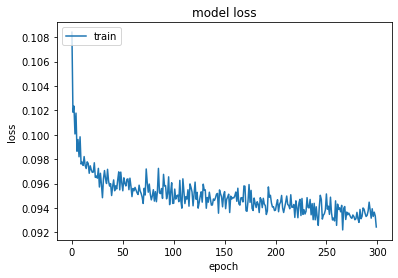

In [62]:
history = myModel.fit( xTrain, yTrain, batch_size=16, epochs=300, verbose=2, shuffle = True, validation_data=( xValid, yValid ), callbacks=[es]) 

# save model
myModel.save( 'Model_NN_2D_CGLE_noise3' + '.h5' )

# save training loss history
with open('history_' + 'Model_NN_2D_CGLE_noise3', 'wb') as file_pi :
    pickle.dump( history.history, file_pi )

print(history.history['loss'][-1])

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#history = model.fit(Xinput, Youtput, epochs=1, batch_size=batch_size, verbose=2, shuffle=False) #batch size: cada 64 imagenes de una misma epoca 

In [63]:
import time
# We now want to make the predictions for the entire region, at every
# time step. We move the neural network one grid point at a time over
# the entire region, making predictions as it moves along. The predictions
# at each grid point are then averaged.
Model = load_model('Model_NN_2D_CGLE_noise3.h5')

DataPred = np.zeros( (1,128,128) ) 

mask = np.zeros( (128,128) )

stride = 2

xInput = X_[-1]
for t in range(1):
  
  
  t0 = time.time()
  for i in range( 0, 128-32+1, stride):   # loop through points in x
    
    #t0 = time.time()

    for j in range( 0, 128-32+1, stride ):   # loop through points in y

      # make predictions at this point

      inputData = np.reshape( xInput[j:j+32,i:i+32], (-1,32,32,1) )
      
      DataPred[t, j:j+32,i:i+32] += np.reshape(Model.predict( inputData ), (32,32))
          
      # update number of predictions made at each grid point
      mask[j:j+32,i:i+32] += 1
  
  DataPred[t] = np.divide( DataPred[t], mask )
  xInput = DataPred[t][:][:]
  t1 = time.time()
    
  if t%5 == 0:
      print(t, "de 100 en ", round(t1-t0, 3), "seg")  # progress update

# average the predictions
#DataPred = np.divide( DataPred, mask )

# rescale psi, either Sx or Sy

DataPred = DataPred * sigma2 + mu2

0 de 100 en  2.338 seg


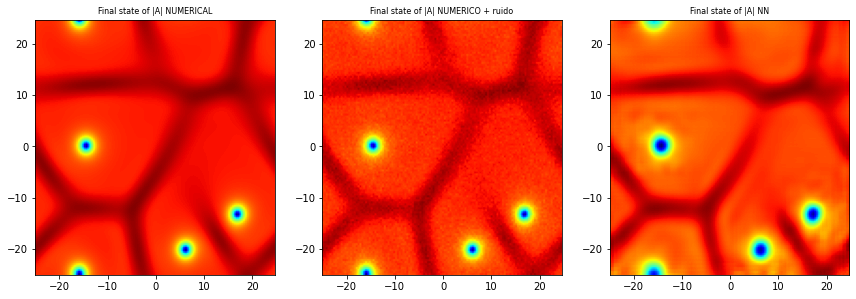

In [64]:
y_graph = Y_Data[-1][:][:]

fig, ax = plt.subplots(1,3,figsize=(1400/96,450/96))

ax[0].imshow(y_graph, extent=[X[0][0], X[0][X.shape[1]-1], X[0][0], X[0][X.shape[1]-1]], aspect='auto', cmap='jet', origin='lower')
ax[0].set_title('Final state of |A| NUMERICAL', fontsize=8)

y_graph = y_[-1]

#ax1.set_figure(figsize=(300/96,350/96), dpi=96)
ax[1].imshow(y_graph, extent=[X[0][0], X[0][X.shape[1]-1], X[0][0], X[0][X.shape[1]-1]], aspect='auto', cmap='jet', origin='lower')
ax[1].set_title('Final state of |A| NUMERICO + ruido', fontsize=8)

y_graph = DataPred[0]
#ax[1].figure(figsize=(300/96,350/96), dpi=96)
im = ax[2].imshow(y_graph, extent=[X[0][0], X[0][X.shape[1]-1], X[0][0], X[0][X.shape[1]-1]], aspect='auto', cmap='jet', origin='lower')
ax[2].set_title('Final state of |A| NN', fontsize=8)
#fig.colorbar(im, ax=ax[1])
plt.savefig('NOISE_MU=0_SIGMA=0,01')
plt.show()